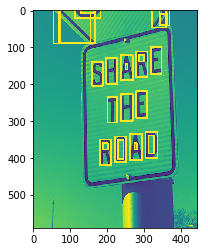

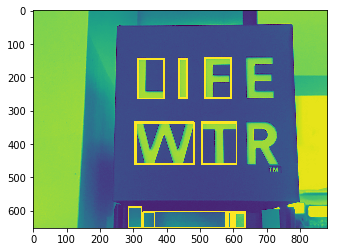

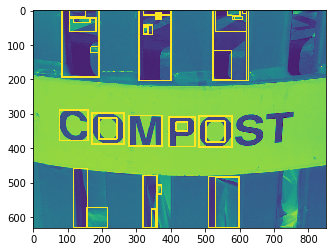

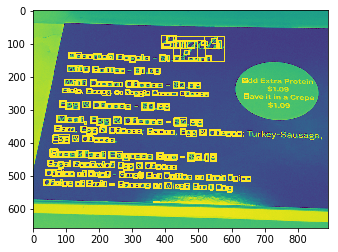

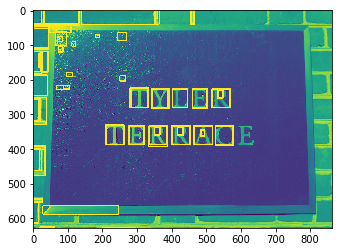

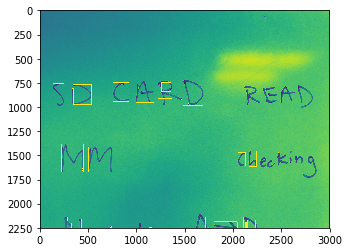

In [147]:
import matplotlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def auto_canny(img, sigma=0.33):
    median = np.median(img)
    lower = int(max(0, (1 - sigma)* sigma))
    upper = int(min(255, (1 + sigma)* sigma))

    return cv2.Canny(img, lower, upper)


mser = cv2.MSER_create()
image_letters = []
for i in range(1,7):
    image_letters.append([])
    img = cv2.imread('image' + str(i) + '.png')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    vis = img_gray.copy()
    # vis = cv2.Canny(img_gray, 30, 200)
    # plt.imshow(vis)
    # plt.show()
    img_gray = cv2.GaussianBlur(img_gray, (3,3), 0)
    # regions = mser.detectRegions(vis)
    regions, _ = mser.detectRegions(img_gray)
    # i = 1
    for region in regions:

        region = np.array(region)
        minX = np.min(region[:, 0])
        maxX = np.max(region[:, 0])
        highestY = np.min(region[:, 1])
        lowestY = np.max(region[:, 1])
        
        if min([minX,maxX,highestY,lowestY]) < 0 or max([minX,maxX]) > img.shape[0] or max([highestY,lowestY]) > img.shape[1]:
            continue

        image_letters[-1].append((None, minX, lowestY, maxX, highestY))

        cv2.rectangle(vis, (maxX, lowestY), (minX, highestY), (255, 0, 0), 2)

    # hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    plt.imshow(vis)
    plt.show()

images_folder = 'images_cropped'
if not os.path.exists(images_folder):
    os.mkdir(images_folder)
image_paths = []
for i,letters in enumerate(image_letters, 1):
    image_file = 'image' + str(i) + '.png'
    image_folder = 'image' + str(i)
    img = cv2.imread(image_file)
    if not os.path.exists(os.path.join(images_folder,image_folder)):
        os.mkdir(os.path.join(images_folder,image_folder))
    for j,letter in enumerate(letters):
#         plt.imshow(img[letter[1]:letter[3],letter[2]:letter[4]])
#         plt.show()
        image_path = os.path.join(images_folder,image_folder,'image'+str(j)+'.png')
        image_paths.append(image_path)
        cv2.imwrite(image_path, img[letter[1]:letter[3],letter[4]:letter[2]])
        
with open('images.txt', 'w') as f:
    for path in image_paths:
        f.write(path+'\n')
    
with open('image_letter_positions.txt', 'w') as f:
    for letters in image_letters:
        f.write(str(letters)+'\n')

In [159]:
import torch


In [158]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans

class Word:
    def __init__(self):
        self.letters = []
        self.minx = None
        self.miny = None
        self.maxx = None
        self.maxy = None
        
    def append(self, letter):
        self.letters.append(letter)
        
    def update_box(self):
        self.minx = min([min(letter.x1,letter.x2) for letter in letters])
        self.miny = min([min(letter.y1,letter.y2) for letter in letters])
        self.maxx = max([max(letter.x1,letter.x2) for letter in letters])
        self.maxy = max([max(letter.y1,letter.y2) for letter in letters])
        
    def position(self):
        self.update_box()
        return [(self.minx + self.maxx)/2, (self.miny+self.maxy)/2]
    
    def add_letters(letters)

                        
class Letter:
    def __init__(self, letter, p1x, p1y, p2x, p2y):
        self.letter = letter
        self.x1 = p1x
        self.y1 = p1y
        self.x2 = p2x
        self.y2 = p2y

    def size(self):
        return np.abs(self.x1-self.x2)*np.abs(self.y1-self.y2)

    def position(self):
        return [(self.x1+self.x2)/2, (self.y1+self.y2)/2]

def grouper(iterable, threshold, function):
    iterable = sorted(iterable, key=function)
    prev = None
    group = []
    for item in iterable:
#         print(function(item)[0])
        if prev is None or function(item) - function(prev) <= threshold:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def choose_letter_distance_group(diff_groups):
    for i in range(len(diff_groups)):
        mean = np.mean(diff_groups[i])
        return i
        
def main(letters_file):
    words = []
    image_letters = []
    with open(letters_file, 'r') as f:
        for line in f:
            image_letters.append([Letter(*letter) for letter in eval(line)])
            
    for i,letters in enumerate(image_letters):
        words.append([])
        sizes = np.array([l.size() for l in letters])
        positions = np.array([[l.position()[0],l.position()[1],i] for i,l in enumerate(letters)])
        plt.scatter(positions[:,0], positions[:,1])
        lines = dict(enumerate(grouper(positions, 15, lambda x:x[1])))
#         print(lines)
        for line in lines.values():
            line = np.array(line)
            plt.scatter(line[:,0], line[:,1])
            diff = [np.abs(x-y) for x, y in itertools.combinations(line[:,0], 2)]
            diff_groups = dict(enumerate(grouper(diff, 10, lambda x:x)))
            i = choose_letter_distance_group(diff_groups)
            if i is None:
                continue
            mean = np.mean(diff_groups[i])
            std = np.std(diff_groups[i])
#             print(mean, std)
            sizes_for_line = [size for i,size in enumerate(sizes) if i in line[:,2]]
            horizontal_cursor = 0
            for letter in line:
                letter_obj = letters[letter[2]]
                if letter_obj.position()[0] > horizontal_cursor:
                    words[-1].append(Word())
                    words[-1][-1].append(letter_obj)
                    words[-1][-1].add_letters(letters, line, )
            break
        break
    
if __name__ == '__main__':
    main('image_letter_positions.txt')

<__main__.Letter instance at 0x111db02d8>
<__main__.Letter instance at 0x111db0170>
<__main__.Letter instance at 0x111db04d0>
<__main__.Letter instance at 0x111db0368>
<__main__.Letter instance at 0x111db00e0>
<__main__.Letter instance at 0x111db0e18>
<__main__.Letter instance at 0x111db0128>
<__main__.Letter instance at 0x111db0ab8>
<__main__.Letter instance at 0x111db0908>
<__main__.Letter instance at 0x111db0758>
<__main__.Letter instance at 0x111db0b48>
<__main__.Letter instance at 0x111db0ef0>
<__main__.Letter instance at 0x111db0d40>
<__main__.Letter instance at 0x111db0998>
<__main__.Letter instance at 0x11174a248>
<__main__.Letter instance at 0x11174a560>
<__main__.Letter instance at 0x11174ac20>
<__main__.Letter instance at 0x11174a4d0>
<__main__.Letter instance at 0x11174a1b8>
<__main__.Letter instance at 0x11174a998>
<__main__.Letter instance at 0x11174aa70>
<__main__.Letter instance at 0x11174ab00>
<__main__.Letter instance at 0x11174ae18>
<__main__.Letter instance at 0x111